<img align="right" width="200" height="200" src="https://avatars3.githubusercontent.com/u/43672704?s=400&u=7f10d18e6375065a2bd501c9cfd59a2ac6ad0f80&v=4">

# MAPD B final project - Distributed computing

**Authors:**
* Alessandro Lambertini - ID: 1242885
* Michele Guadagnini    - ID: 1230663


In [1]:
## useful packages
# dask
from dask.distributed import Client, LocalCluster
from dask import delayed
import dask.bag as db
import dask.dataframe as ddf
import dask.array as da

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('stopwords')
#nltk.download('wordnet')

# fasttext
import fasttext
import fasttext.util

# others
import string
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import json
import io
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Analysis of Covid-19 papers

Since this year our activities are determined by the COVID-19 pandemic, the distributed computing project will be focused on the analysis of 1000 papers about COVID-19, SARS-CoV-2, and related corona viruses. 
The dataset is a sub-sample of 1000 items taken from the original dataset that is composed of more than 75000 papers. 
This dataset is a part of real-world research on COVID-19 named COVID-19 Open Research Dataset Challenge (CORD-19).

## 1) Word counter distributed algorithm

The aim of this first assignment is to count the occurrences of all the words in all the documents through a distributed algorithm and to show the most frequent ones and their relation to viruses and research.
To complete this task, the first thing we need to do is to convert our data from structured to single-lined dictionaries because the ' *\n* ' characters cause a *JSONDecodeError*.

In [2]:
# storing data into flatten dictionaries
path    = "data/papers_in_json/"
outpath = "data/papers_in_json_flatten/"
filenames = os.listdir(path)

# checking if folder already exist
if not os.path.isdir(outpath):
    os.mkdir(outpath)
    
    for ff in filenames:
        with open(path+ff, "r") as fjs:
            file = fjs.read()
        temp = json.loads(file)
        temp = json.dumps(temp, separators=(',',':'))
        with open(outpath+ff, 'w') as out:
            out.write(temp)

In the following cell we create a list of words that are not meaningful for our analysis and that we will remove from the text if present. We build this list by using the *stopwords* module from the library *nltk*, adding the alphabet characters and other words that are sometimes present.

In [3]:
# building the list of words to be removed
stopwords_list = stopwords.words('english')
stopwords_list.extend(['one','two','three','four','five','six','seven','eight','nine','ten',
                       'also', 'must', 'best', 'whether', 'may','eg','ie','could','al','et',
                       'fig','due','many','however'])
stopwords_list.extend(list(string.ascii_lowercase))

In the cell below we define a function *transform* that we will use to merge all the *body_text* fields inside a document and split the whole text into single words transformed to lower case. It also cleans text from *punctuation*, *stopwords* and *numbers*. <br>
We also added a step that, using *WordNetLemmatizer* from *nltk*, let us group similar words (like singular and plural form), avoiding to count them separately. This last operation can be disabled by calling the function with the option *lemmatize = False*.

In [4]:
# initializing the lemmatizer
lmtzr = WordNetLemmatizer()

# Function that merge al the text segments and split them in a list of words. 
# It remove from the list numbers and stopwords returning a list of significant words.
def transform(record, lemmatize=True):   
    temp = ''
    
    # merging all the 'text' fields of one document
    for rr in record:
        temp += rr["text"]
        
    # removing punctuation
    temp = temp.translate(str.maketrans('','',string.punctuation))
        
    # splitting the words
    temp = temp.split()
    
    # lowering all the words
    temp = map(lambda x:x.lower(),temp)
    
    # removing pure numbers
    temp = [tt for tt in temp if not tt.isnumeric()]       
    
    # remove the stopwords
    temp = [x for x in temp if x not in stopwords_list]
    
    # grouping similar words
    if (lemmatize==True):
        temp = [lmtzr.lemmatize(word) for word in temp]
        
    return temp

In the cell below we define a function *WordsCounter* that allows us to easily run the algorithm with different configurations of workers and partitions to check the execution time. The function is composed as follow:
* a client is initialized with the provided number of workers *Nworkers*
* data are loaded in **dask.bag** object and repartitioned accordingly with the argument passed, *Nparts*
* the fields *body_text* are selected and the function *transform* is applied to all the documents
* using the function *flatten()* all the words lists resulting from the previous step are merged and, using the function *frequencies()*, the overall words occurrencies are computed and sorted. All operation are executed only when the function *compute()* is called
* the client is closed and results are returned.

The function also measures the execution time (*time_elapsed*) of its main parts.

In [5]:
def WordsCounter(Nworkers, Nparts, full_return=False, Lemmatize=True):
    # Make a client
    client = Client(n_workers=Nworkers)
    
    # Load data and repartition
    filename = os.path.join(outpath+'*.json')
    ln       = db.read_text(filename)
    js_bag   = ln.map(json.loads).repartition(Nparts)
    
    start_time = time.time()                   # starting the stopwatch
    
    # selecting body-text and sanitizing
    words_list = js_bag.pluck("body_text").map(transform,lemmatize=Lemmatize)
    
    # counting the words occurrences
    words_frequencies = words_list.flatten().frequencies(sort=True).compute()
    
    time_elapsed = time.time() - start_time    # stopping the time measurement
    
    # closing client
    client.close()
    
    # selecting type of return
    if full_return:
        return words_frequencies, time_elapsed
    else:
        return time_elapsed

### 1.1) Timings analysis

Below we create two lists for the function arguments, then we do a loop over these values. Hence we obtain a matrix of timings that we plot in a heat map to easily find out the best configuration. Obviously, the best configuration depends on the characteristics of the machine/machines used.

In [6]:
Nwk_list = np.array([1,2,4,8])
Npt_list = np.array([2,4,8,16,32,64,128])

# looping over configurations
time_mat = np.zeros((len(Nwk_list),len(Npt_list)))
for ii in range(len(Nwk_list)):
    for jj in range(len(Npt_list)):
        # disabling lemmatization due to:
        # AttributeError: 'WordNetCorpusReader' object has no attribute '_LazyCorpusLoader__args'
        time_mat[ii,jj] = WordsCounter(Nwk_list[ii], Npt_list[jj], Lemmatize=False)
        #print("Nwk =", Nwk_list[ii], "; Npt = ", Npt_list[jj], "; -> time =", time_mat[ii,jj])
        

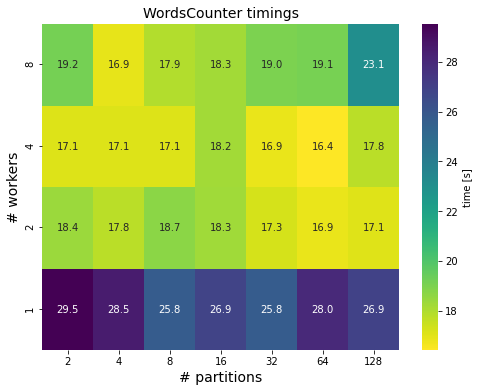

In [7]:
# timings heatmap
plt.figure(figsize = (8,6))
ax = sns.heatmap(time_mat,cmap='viridis_r',yticklabels=Nwk_list, xticklabels=Npt_list, 
                 annot=True, fmt=".1f", cbar_kws={'label': 'time [s]'})
ax.set_title("WordsCounter timings",fontsize=14)
ax.set_ylabel("# workers",   fontsize=14)
ax.set_xlabel("# partitions",fontsize=14)
ax.invert_yaxis()
plt.show()

### 1.2) WordsCounter results

Now that we know the best configuration we use it to compute the words occurence by mean of the same function above, this time with the argument `full_return=True` and enabling also *lemmatization*. In this way we can finally retrieve the top words and make a barplot of them.

In [8]:
# getting the best config
(best_wk_id, best_pt_id) = np.unravel_index(np.argmin(time_mat, axis=None), time_mat.shape)
best_Nwk = Nwk_list[best_wk_id]
best_Npt = Npt_list[best_pt_id]

# computing the words occurrencies (this time with lemmatization)
words_frequencies, exec_time = WordsCounter(best_Nwk, best_Npt, full_return=True)

print("Configuration used: # workers:", best_Nwk, "| # partitions:", best_Npt)
print("Execution time (with lemmatization):", exec_time)

Configuration used: # workers: 4 | # partitions: 64
Execution time (with lemmatization): 35.12765908241272


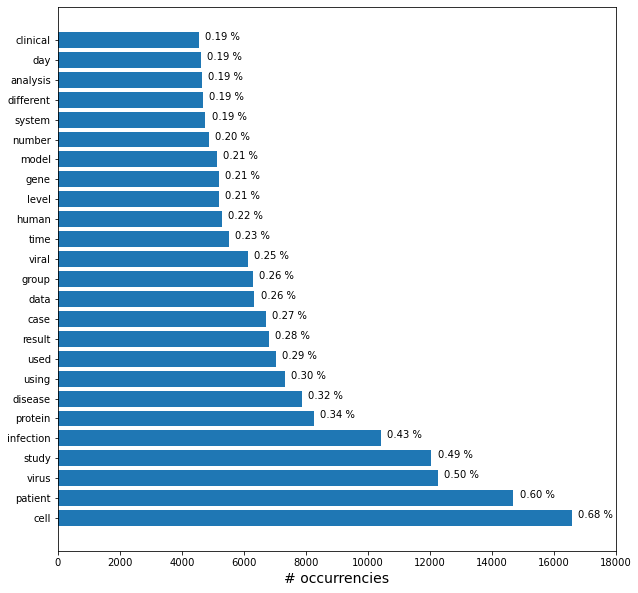

In [9]:
# bar-plotting the top words
Ntop = 25
words_frequencies_plot = words_frequencies[0:Ntop]

words = [x[0] for x in words_frequencies_plot]
freqs = [x[1] for x in words_frequencies_plot]

x_pos = np.arange(len(words))

fig, ax = plt.subplots(figsize=(10,10))
ax.barh(x_pos, freqs, align='center')
ax.set_xlabel("# occurrencies", fontsize=14)
ax.set_xlim(0,18000)
plt.yticks(x_pos, words)

# adding percentages labels computed over top words 
norm = sum([x[1] for x in words_frequencies])
for i in range(len(words_frequencies_plot)):
    plt.text(freqs[i]+200, x_pos[i], "{0:0.2f} %".format((100*freqs[i]/norm)))
    
plt.show()

## 2)  Best represented countries and institutes

In this section we are asked to identify which countries and institutes are more active in COVID-19 research. To do this we import the data with a **dask.bag** object and then, by applying some filtering functions, we build up a **dask.dataframe** that we can use for our analysis.

### 2.1) Top countries

The procedure we used can be described as follows:
* we select only the `authors` field since it contains all the needed informations and apply *flatten()* to it
* we filter it from empty dictionaries that are eventually present and retrieve the `affiliation` field
* we define and apply the function `flatten` in order to get a flat dictionary with only the field `country`, dealing also with missing data
* we transform the *bag* object into a *dataframe* with the function *to_dataframe()*
* we remove the lines that are empty in the column `country` and clean the countries names from punctuation
* Finally, we use *value_counts()* to get the occurrences of the countries and call *compute()*.

In order to easily perform a timing analysis we put all these operations into the function *TopCountries* and we loop over different configurations of workers and partitions as done in the previous section.

In [10]:
# function to select only useful information
def flatten(record):    
    if ('location' in record.keys()):
        if ('country' in record['location'].keys()):
            country = record['location']['country']
        else:
            country = 'Empty'
    
    return { "country" : country }

# remove punctuation
def clean_punctuation(rec):
    name = rec.translate(str.maketrans('', '', string.punctuation))
    return(name)

In [11]:
def TopCountries(Nworkers, Nparts, full_return=False):
    # Make a client
    client = Client(n_workers=Nworkers)
    
    # Load data and repartition
    filename = os.path.join(outpath+'*.json')
    ln       = db.read_text(filename)
    js_bag   = ln.map(json.loads).repartition(Nparts)
    
    start_time = time.time()                    # starting the stopwatch
    
    # bag operations
    authors   = js_bag.map(lambda record: record['metadata']['authors']).flatten()
    affils    = authors.filter(lambda record: record['affiliation'] != {}).pluck('affiliation')
    df_affils = affils.map(flatten).to_dataframe()
    
    # dataframe operations
    df_countries   = df_affils[df_affils['country']!='Empty']
    country_weight = df_countries['country'].map(clean_punctuation).value_counts().to_frame().compute()
    
    time_elapsed = time.time() - start_time     # stopping the time measurement
    
    # closing client
    client.close()
    
    # selecting type of return
    if full_return:
        return country_weight, time_elapsed
    else:
        return time_elapsed

### 2.1.1) Timings analysis for TopCountries function

Below we perform the same timings analysis done for the *WordsCounter*.

In [12]:
Nwk_list = np.array([1,2,4,8])
Npt_list = np.array([2,4,8,16,32,64,128])

# looping over configurations
time_mat = np.zeros((len(Nwk_list),len(Npt_list)))
for ii in range(len(Nwk_list)):
    for jj in range(len(Npt_list)):
        time_mat[ii,jj] = TopCountries(Nwk_list[ii], Npt_list[jj])
        #print("Nwk =", Nwk_list[ii], "; Npt = ", Npt_list[jj], "; -> time =", time_mat[ii,jj])

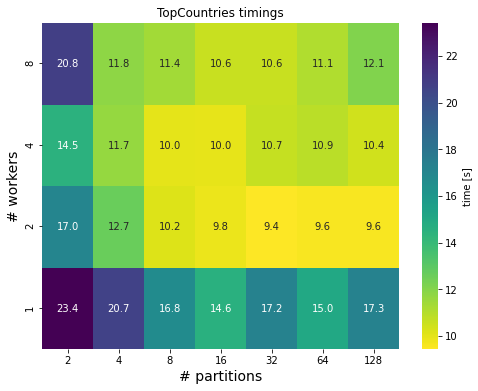

In [13]:
# timings heatmap
plt.figure(figsize = (8,6))
ax = sns.heatmap(time_mat,cmap='viridis_r',yticklabels=Nwk_list, xticklabels=Npt_list, 
                 annot=True, fmt=".1f", cbar_kws={'label': 'time [s]'})
ax.set_title("TopCountries timings")
ax.set_ylabel("# workers",   fontsize=14)
ax.set_xlabel("# partitions",fontsize=14)
ax.invert_yaxis()
plt.show()

### 2.1.2) TopCountries results

Here we run the function again with the best parameters discovered above.

In [14]:
# getting the best config
(best_wk_id, best_pt_id) = np.unravel_index(np.argmin(time_mat, axis=None), time_mat.shape)
best_Nwk = Nwk_list[best_wk_id]
best_Npt = Npt_list[best_pt_id]

# computing the countries occurrencies
country_weight, exec_time = TopCountries(best_Nwk, best_Npt, full_return=True)

print("Configuration used: # workers:", best_Nwk, "| # partitions:", best_Npt)
print("Execution time:", exec_time)

Configuration used: # workers: 2 | # partitions: 32
Execution time: 9.77822470664978


The name of the countries is not always written in the same way or sometimes contain errors or is written in a different language from *English*. We found out that implementing an automatic method to replace all the different names with a common one is not trivial.  <br>
So, in the cell below, we do it manually for the most important countries in our analysis.
Then we aggregate the fields with the same name summing their counts of the occurrencies. We also sort again the dataframe.

In [15]:
#reduction of the error by renaming the countries all in the same way
country_weight = country_weight.reset_index()

country_weight = country_weight.replace(['United States',
                                         'United States of America',
                                         'USA USA'], 'USA')
country_weight = country_weight.replace(['PR China',
                                         'Peoples Republic of China',
                                         'China China China',
                                         'China Peoples Republic of China',
                                         'P R China'],'China')
country_weight = country_weight.replace(['the Netherlands',
                                         'the Netherlands the Netherlands',
                                         'the Netherlands the Netherlands the Netherlands I Thurkow The Netherlands',
                                         'Netherlands'],'The Netherlands')
country_weight = country_weight.replace(['Republic of Korea',
                                         'Korea Republic of Korea'],'Korea')
country_weight = country_weight.replace('Taiwan ROC','Taiwan')
country_weight = country_weight.replace('United Kingdom','UK')
country_weight = country_weight.replace(['Singapore Singapore',
                                         'Republic of Singapore'],'Singapore')
country_weight = country_weight.replace(['España',
                                         'España España',
                                         'España  España',
                                         'Spain Spain'],'Spain')
country_weight = country_weight.replace('Deutschland','Germany')
country_weight = country_weight.replace('Portugal Portugal','Portugal')
country_weight = country_weight.replace('France France','France')
country_weight = country_weight.replace('Russian Federation','Russia')

In [16]:
# sum counts for the countries with same name
TotCountries = (country_weight.groupby(country_weight['index'])
                              .aggregate({'index': 'first', 'country': 'sum'})
                              .sort_values('country',ascending=False))

In [17]:
TotCountries.columns = ['Country','Authors_counts']
TotCountries = TotCountries.reset_index(drop=True)

Finally, we produce a barplot that represents the top countries in the COVID-19 research. We decided to plot the first 20 countries. <br>
The counts represent the number of times that an author of a certain nationality appear in a paper. 

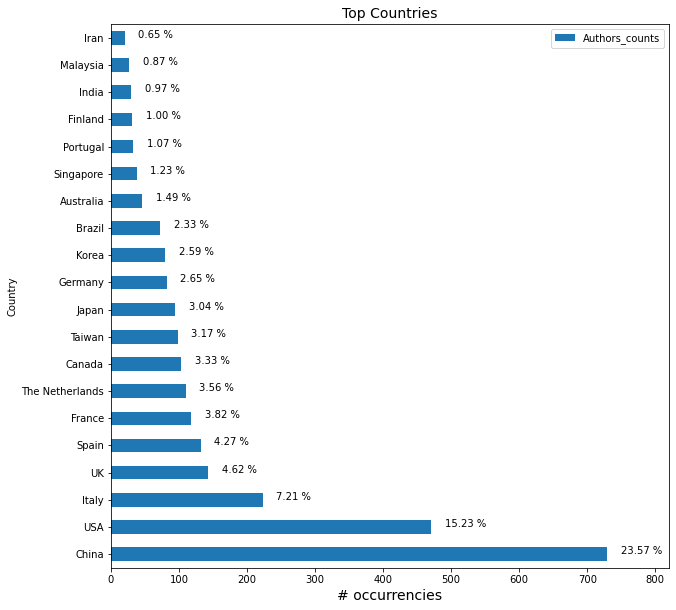

In [18]:
# getting the best and worst countries
TopCs   = TotCountries.head(20)
WorstCs = TotCountries.tail(20)

x_pos = np.arange(len(TopCs))

fig, ax = plt.subplots(figsize=(10,10))
# Top countries
ax = TopCs.plot.barh(x='Country', y='Authors_counts',ax=ax)
ax.set_title("Top Countries", fontsize=14)
ax.set_xlabel("# occurrencies", fontsize=14)
ax.set_xlim(0,820)

# adding percentages labels computed over top words 
Norm = TotCountries['Authors_counts'].sum()
for i in range(len(TopCs)):
    plt.text(TopCs['Authors_counts'][i]+20, x_pos[i], "{0:0.2f} %".format((100*TopCs['Authors_counts'][i]/Norm)))
    
plt.show()

# Worst countries
#WorstCs.head(20)

### 2.2) Top institutes

In this section we want to perform the same analysis done before but on *Institutes* and *Laboratories* instead of countries. For this purpose we redefine the `flatten` function in order to retrieve only the useful fields. Then we build the new function `TopInstitutes` by adapting `TopCountries`, changing only the part regarding *dataframe operations*. We decided to merge the two fields *Institutes* and *Laboratories* and make a unique ranking.

In [19]:
# function to select only useful information
def flatten(record):
    if ('laboratory' in record.keys()):
        laboratory = record['laboratory']
    else:
        laboratory = 'Empty'
    
    if ('institution' in record.keys()):
        institution = record['institution']
    else:
        institution = 'Empty'
    
    return { "laboratory" : laboratory,
             "institution": institution }

In [20]:
def TopInstitutes(Nworkers, Nparts, full_return=False):
    # Make a client
    client = Client(n_workers=Nworkers)
    
    # Load data and repartition
    filename = os.path.join(outpath+'*.json')
    ln       = db.read_text(filename)
    js_bag   = ln.map(json.loads).repartition(Nparts)
    
    start_time = time.time()                    # starting the stopwatch
    
    # bag operations
    authors   = js_bag.map(lambda record: record['metadata']['authors']).flatten()
    affils    = authors.filter(lambda record: record['affiliation'] != {}).pluck('affiliation')
    df_affils = affils.map(flatten).to_dataframe()
    
    # dataframe operations
    df_insts  = df_affils['institution'].rename("affiliation")
    df_labs   = df_affils['laboratory' ].rename("affiliation")
    df_Affils = ddf.concat([df_insts,df_labs],axis=0,interleave_partitions=True)
    df_Affils = df_Affils.value_counts().to_frame().compute()
  
    time_elapsed = time.time() - start_time     # stopping the time measurement
    
    # closing client
    client.close()
    
    # selecting type of return
    if full_return:
        return df_Affils, time_elapsed
    else:
        return time_elapsed

### 2.2.1) Timings analysis of TopInstitutes function

In [21]:
Nwk_list = np.array([1,2,4,8])
Npt_list = np.array([2,4,8,16,32,64,128])

# looping over configurations
time_mat = np.zeros((len(Nwk_list),len(Npt_list)))
for ii in range(len(Nwk_list)):
    for jj in range(len(Npt_list)):
        time_mat[ii,jj] = TopInstitutes(Nwk_list[ii], Npt_list[jj])
        #print("Nwk =", Nwk_list[ii], "; Npt = ", Npt_list[jj], "; -> time =", time_mat[ii,jj])

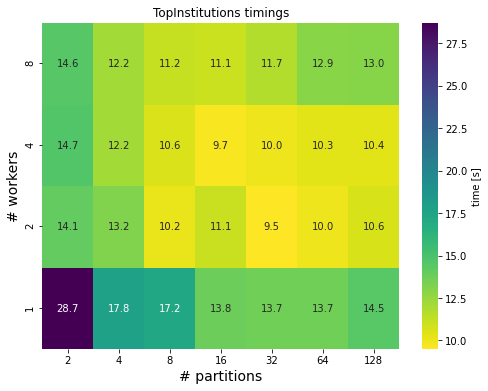

In [22]:
# timings heatmap
plt.figure(figsize = (8,6))
ax = sns.heatmap(time_mat,cmap='viridis_r',yticklabels=Nwk_list, xticklabels=Npt_list, 
                 annot=True, fmt=".1f", cbar_kws={'label': 'time [s]'})
ax.set_title("TopInstitutions timings")
ax.set_ylabel("# workers",   fontsize=14)
ax.set_xlabel("# partitions",fontsize=14)
ax.invert_yaxis()
plt.show()

### 2.2.2) TopInstitutes results

In [23]:
# getting the best config
(best_wk_id, best_pt_id) = np.unravel_index(np.argmin(time_mat, axis=None), time_mat.shape)
best_Nwk = Nwk_list[best_wk_id]
best_Npt = Npt_list[best_pt_id]

# computing the countries occurrencies
df_Affils, exec_time = TopInstitutes(best_Nwk, best_Npt, full_return=True)

print("Configuration used: # workers:", best_Nwk, "| # partitions:", best_Npt)
print("Execution time:", exec_time)

Configuration used: # workers: 2 | # partitions: 32
Execution time: 11.096423864364624


In the cells below we manipulate the resulting dataframe by removing the empty fields *('')* that are present in high number, by resetting the indices and by renaming the columns. We also change the name of one institute since it is very long to use in a plot.

In [24]:
df_Affils = df_Affils.drop('') # dropping empty fields
df_Affils = df_Affils.reset_index()
df_Affils.columns = ["affiliation","counts"]

# we replace this lab name since it is too long for plotting
df_Affils = df_Affils.replace("M.P. Koopmans); Public Health Service Haaglanden, The Hague, the Netherlands (K. Dirksen); Medical Centre Haaglanden, The Hague (C. Jansen, L.B.S. Gelinck, E.M.S. Leyten); Public Health Service Ijsselland",
                              'Public Health Service Haaglanden et al.')

df_Affils.head(20)

,affiliation,counts
0,The University of Hong Kong,57
1,Verona University Hospital Trust,55
2,Chinese Academy of Sciences,42
3,University of California,29
4,Third Military Medical University,27
5,Public Health Service Haaglanden et al.,26
6,Fudan University,26
7,Huazhong Agricultural University,26
8,Utrecht University,25
9,National Institutes of Health,23


Below we produce the same barplot we presented in the section regarding countries. 

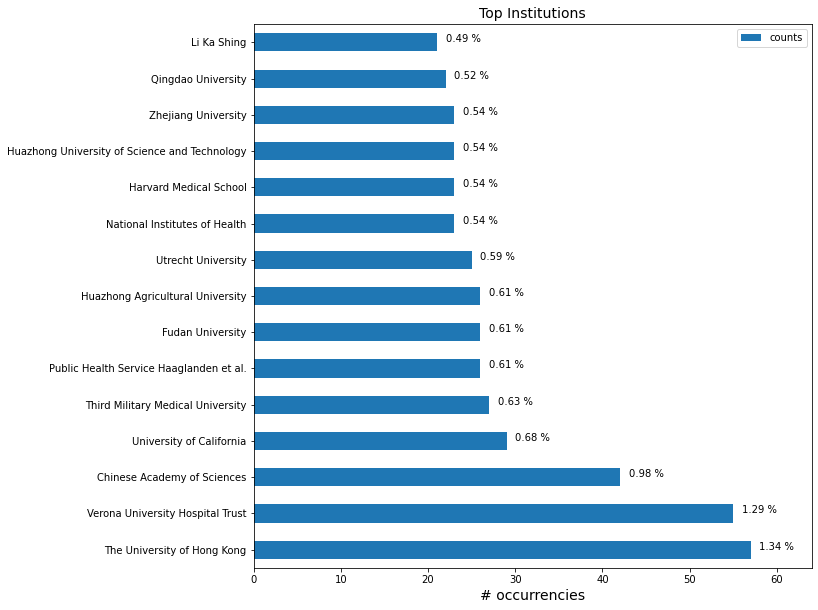

In [25]:
# getting the best and worst institutes
TopAffs   = df_Affils.head(15)
WorstAffs = df_Affils.tail(15)

x_pos = np.arange(len(TopAffs))

fig, ax = plt.subplots(figsize=(10,10))
# Top Institutions
ax = TopAffs.plot.barh(x='affiliation', y='counts',ax=ax)
ax.set_title("Top Institutions", fontsize=14)
ax.set_xlabel("# occurrencies", fontsize=14)
ax.set_ylabel("", fontsize=14)
ax.set_xlim(0,64)

# adding percentages labels computed over top words 
Norm = df_Affils['counts'].sum()
for i in range(len(TopAffs)):
    plt.text(TopAffs['counts'][i]+1, x_pos[i], "{0:0.2f} %".format((100*TopAffs['counts'][i]/Norm)))
    
plt.show()

# Worst countries
#WorstAffs.head(20)

## 3 Get the embedding for the title of the papers

In NLP a common technique to perform analysis over a set of texts is to transform the text to a set of vectors each one representing a word inside a document.

At the end of the pre-processing the document will be transformed into a list of vectors or a matrix.
What you can do is to transform the title of the paper into its embedding version by us- ing the pre-trained model available on FastText.
Basically the pre-trained model is more or less a huge dictionary in the following format key : vector.

Since the model proposed by the Prof. is too heavy to upload, we choose a little-lighter version of it to complete the tasks.

In [26]:
#Download the model
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
#!gzip -d cc.en.300.bin.gz

#Load the model
ft = fasttext.load_model('cc.en.300.bin')

In [27]:
#function: pre-processing of the titles and setting a proper data-structure:
def transform_title(record,lemmatize = True,remove_stopwords=True):   
    temp = ''
    
    # Selecting the title
    temp = record['metadata']["title"]
    paper_id = record['paper_id']   
    
    # removing punctuation
    temp = temp.translate(str.maketrans('', '', string.punctuation))
        
    # splitting the words
    temp = temp.split()
    
    # lowering all the words
    temp = map(lambda x:x.lower(),temp)     
    
    # remove the stopwords
    if (remove_stopwords==True):
        temp = [x for x in temp if x not in stopwords_list]
    
    #lemmatize the title
    if (lemmatize == True):
        lmtzr = WordNetLemmatizer()
        temp = [lmtzr.lemmatize(word) for word in temp]
        
    return {'paper_id' : paper_id,'original_title' : record['metadata']['title'],'title' : temp}

In [28]:
#function: filtering the empty records and applying the model
def apply_model(record):
    if record['title'] != []:
        title_embedded = [ft.get_word_vector(x) for x in record['title']]
        title_embedded = np.vstack(title_embedded)
    else:
        title_embedded = np.array([1])
        
    title = record['title']
    p_id = record['paper_id']
    return {'paper_id' : p_id,'original_title' : record['original_title'],
            'title' : title, 'emb_title' : title_embedded}

### We can't apply the model in parallel:

We can't apply the model in parallel because every worker try to upload the model and this kill the process.
Every Dask worker handle his own memory, when it is full for over the 95% the worker is resetted, indeed the model weight, once unzipped, is 7,24 GB on disk.

When we tried to run the process in parallel we obtained the following error:

`KilledWorker: ("('apply_model-filter-lambda-repartition-transform_title-take-26b86798d7fad82e0442c72fd6484fed', 0)", <Worker 'tcp://127.0.0.1:51773', name: 2, memory: 0, processing: 1>)`

The code we used:

`paper_id_title = js_bag.map(transform_title)`<br>
`paper_id_title = paper_id_title.map(apply_model)`<br>
`paper_id_title = paper_id_title.filter(lambda record: len(record['emb_title']) > 1)`

In order to not run the model everytime we save the embedded titles in json files:

## 3.1 Bonus point:

Use the previously generated vectors to compute the cosine similarity between each paper and to figure out a couple of papers with the highest cosine similarity score.

In [29]:
# Load embedded titles and compute a list of them through dask:
filename = os.path.join('data/embedded_papers/*.json')
emb_dict = db.read_text(filename)
js_bag   = emb_dict.map(json.loads).repartition(10)

tit_emb = js_bag.compute()

The first problem we encountered trying to solve the task is the fact that our model associates an array to each word, but we have to somehow compare entire phrases. A phrase can be represented by a matrix or trough a long array obtained concatenating the arrays representing each word in the phrase. 

Followind the second approach we would end up with an array for each phrase and we could therefore compute the inner product between a couple of them. The problem is that in this way we are keeping trace of the order of the words in a phrase and, when comparing two phrases, we are forced to ignore the last part of the longer phrase.

We tried two different approaches: with both of them we take into account every words in each titles and we don't care about the order in which they appear.

## First method: matrix



* We represent our phrases through matrices: we compute the cosine-similarity between all the combinations of words in the two matrices, obtaining another matrix. The measure of the correlation between two phrases is then the Frobenius norm of the resulting matrix divided by the square root of the number of columns (i.e. the number of elements in the diagonal of $A^*A$), $\frac{\|A_{n\times m}\|_F}{\sqrt{m}}$. The Frobenius norm is defines as:

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/d727134770f3e3275994cfc1fd5c75f8073394a8">

where $\sigma_i(A)$ are the singular values of $A$.

In [30]:
#compute the matrix for the heat map:
ij = np.zeros((len(tit_emb),len(tit_emb)))
for i in range(len(tit_emb)):
    for j in range(i,len(tit_emb)):
            a = cosine_similarity(tit_emb[i]['emb_title'], tit_emb[j]['emb_title'])
            a = np.linalg.norm(a,ord='fro')/np.sqrt(max(a.shape))
            ij[i,j] = a

In [31]:
#completing the symmetric matrix with the lower triangular part:
ij_complete = ij + ij.T - np.diag(np.diag(ij))

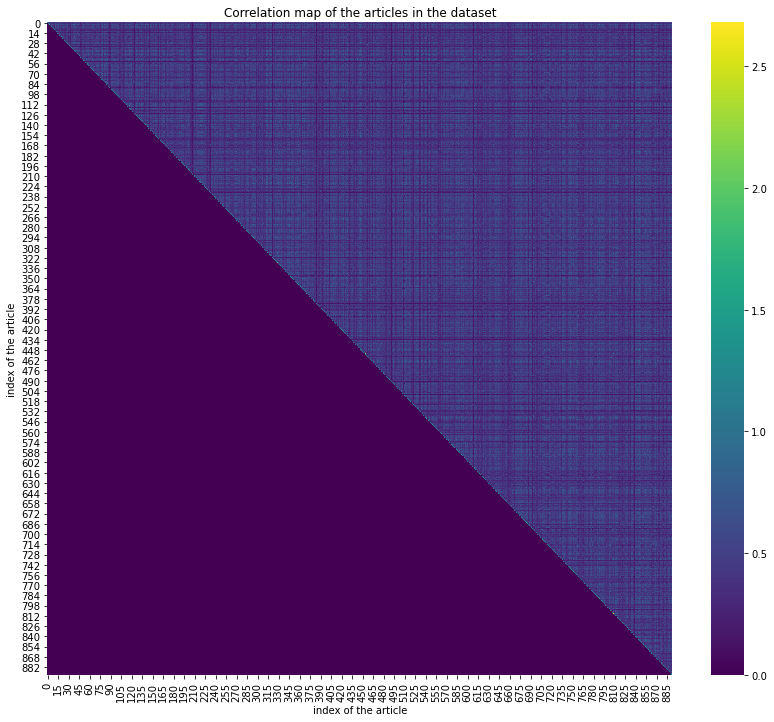

In [32]:
#Plotting and saving the heat-map for the upper triangular matrix:
plt.figure(figsize = (14,12))
ax = sns.heatmap(ij,cmap='viridis')
ax.set_xlabel('index of the article') 
ax.set_ylabel('index of the article')  
ax.set_title("Correlation map of the articles in the dataset") 
#plt.savefig('half_matrix_norm_method.pdf')

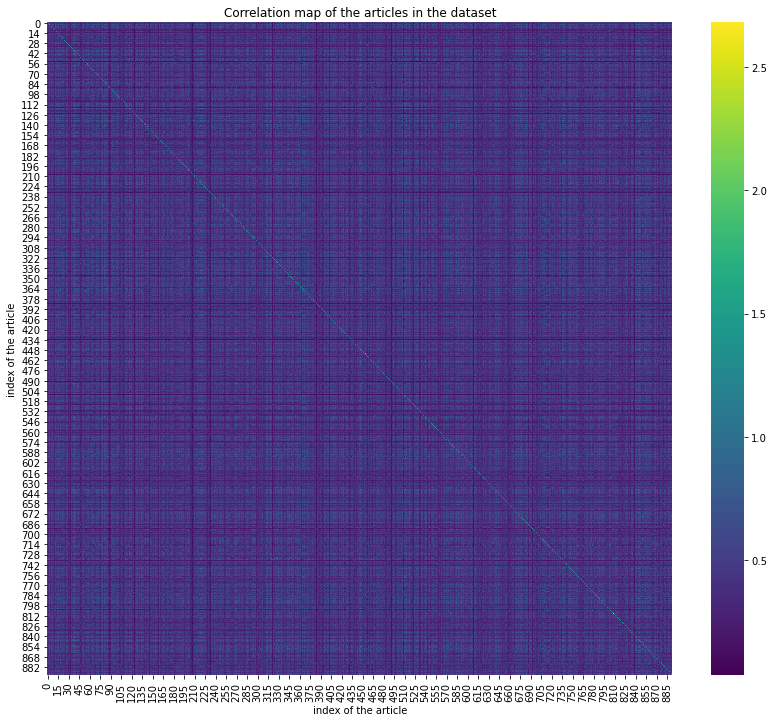

In [33]:
#plotting and saving the heat-map for the complete matrix:
plt.figure(figsize = (14,12))
ax = sns.heatmap(ij_complete,cmap='viridis')
ax.set_xlabel('index of the article') 
ax.set_ylabel('index of the article')  
ax.set_title("Correlation map of the articles in the dataset")  
#plt.savefig('complete_matrix_norm_method.pdf')

In [34]:
#function: compute the couple of indeces of the cosine similarity matrix with the highest value:
def sort_indices(ary):
    return np.dstack(np.unravel_index(np.argsort(-ary.ravel()), ary.shape))[0]

#most correlated papers
sorted_id = sort_indices(np.tril(ij_complete))

#most correlated papers EXCLUDING THE DIAGONAL
indices    = [i for i in sorted_id  if(i[0]!=i[1])]
first_art  = np.array([i[0] for i in indices ])
second_art = np.array([i[1] for i in indices ])

In [35]:
#List of original titles:
litteral_title = js_bag.pluck('original_title').compute()

In [36]:
#Sorting the list of original titles by their cosine similarity value:
first_art_title = [litteral_title[j] for j in first_art]
second_art_title = [litteral_title[j] for j in second_art]

##Sorting the list of cosine similarity value:
art_cor_value = [ij_complete[i,j] for (i,j) in zip(first_art,second_art)]

In [37]:
N_sample = 100
#Creating a dataframe of N_samples rows with the above information:
df = pd.DataFrame(data=np.column_stack((first_art_title[:N_sample],
                  second_art_title[:N_sample],art_cor_value[:N_sample])),
                  columns=['Paper 1','Paper 2','Cos_sim'])

In [38]:
N=20
#Show the first N entries of the dataframe:
df.head(N)

,Paper 1,Paper 2,Cos_sim
0,Chapter Outline Introduction and Basic Anatomy...,Scientific Sessions B Scientific Sessions (B) ...,1.3653230131379843
1,Chapter Outline Introduction and Basic Anatomy...,0:35 Smets Smets EFFECT OF SAMPLING METHOD AND...,1.3510222068816278
2,Scientific Sessions B Scientific Sessions (B) ...,0:35 Smets Smets EFFECT OF SAMPLING METHOD AND...,1.3082673655155956
3,Chapter Outline Introduction and Basic Anatomy...,The microbiological characteristics of lower r...,1.2297523334311817
4,Differential innate immune response programs i...,Supplementary Information Differential innate ...,1.1812459156832709
5,Journal Pre-proof Guidance for rebooting elect...,Journal Pre-proof Impact of COVID-19 pandemic ...,1.1605651497884166
6,Relationships between A(H1N1)pdm09 influenza i...,Immunosuppressed patients with pandemic influe...,1.1505452293133096
7,Journal Pre-proof Tandem mass spectrometry of ...,Clinical Infectious Diseases Vancomycin Monoth...,1.1472648477185239
8,Estudio retrospectivo de 10 años de la infecci...,M I C R O B I O L O G Í A Diagnóstico de virus...,1.143005197646964
9,Echoes of 2009 H1N1 Influenza Pandemic in the ...,Immunosuppressed patients with pandemic influe...,1.1355989219635256


In [39]:
#If complete visualization of titles is required:
M = 6
print(df['Paper 1'][M],'\n')
print(df['Paper 2'][M])
print(df['Cos_sim'][M])

Relationships between A(H1N1)pdm09 influenza infection and infections with other respiratory viruses 

Immunosuppressed patients with pandemic influenza A 2009 (H1N1) virus infection
1.1505452293133096


### Comments:
With this method we see heuristically that the probability of having a high correlation is larger for long titles. This is due to the norm we exploit to measure the correlation. Therefore, we try with a different method.

# Second method: sum

We represent phrases by summing element-wise the arrays that represent each word in them. In this way we get an 'average position' of the phrase in the space of the words. Therefore, we are free to compute the cosine similarity between these new arrays that represent each title in our dataset.

In [40]:
#Selecting the embedded titles:
titles = js_bag.pluck('emb_title')

#Defining the function to compute the average position:
whole_title_emb = lambda x: [np.sum(t) for t in zip(*x)]

#Compute the list formed by the vectors representing the average position of each title:
concat_titles = titles.map(whole_title_emb).compute()

#Compute the cosine similarity for each couple of titles:
titles_correlation = cosine_similarity(concat_titles, concat_titles)
print('the correlation between a title and itself is:',titles_correlation[1][1])

the correlation between a title and itself is: 0.9999999999999994


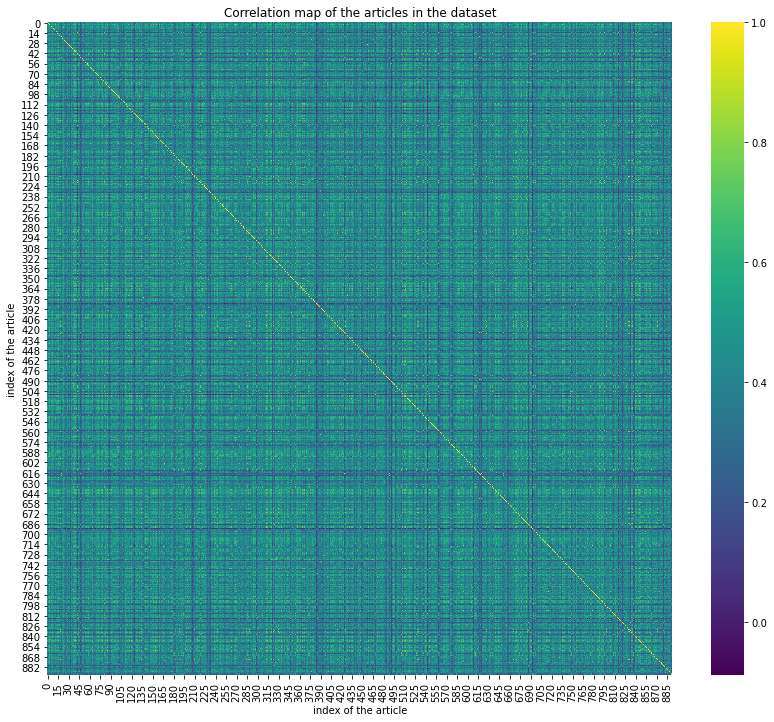

In [41]:
#plotting and saving the heat-map for the complete matrix
plt.figure(figsize = (14,12))
ax = sns.heatmap(titles_correlation,cmap='viridis')
ax.set_xlabel('index of the article') 
ax.set_ylabel('index of the article')  
ax.set_title("Correlation map of the articles in the dataset") 
#plt.savefig('complete_matrix_sum_method.pdf')

In [42]:
#most correlated papers
sorted_id = sort_indices(np.tril(titles_correlation))

#most correlated papers excluding the diagonal
indices = [i for i in sorted_id if(i[0]!=i[1])]
first_art = np.array([i[0] for i in indices ])
second_art = np.array([i[1] for i in indices ])

In [43]:
#List of original titles:
litteral_title = js_bag.pluck('original_title').compute()

In [44]:
#Sorting the list of original titles by their cosine similarity value:
first_art_title = [litteral_title[j] for j in first_art]
second_art_title = [litteral_title[j] for j in second_art]

##Sorting the list of cosine similarity value:
art_cor_value = [titles_correlation[i,j] for (i,j) in zip(first_art,second_art)]

In [45]:
N_sample = 100
#Creating a dataframe of N_samples rows with the above information:
df = pd.DataFrame(data=np.column_stack((first_art_title[:N_sample],
                  second_art_title[:N_sample],art_cor_value[:N_sample])),
                  columns=['Paper 1','Paper 2','Cos_sim'])

In [46]:
N=20
#Show the first N entries of the dataframe:
df.head(N)

,Paper 1,Paper 2,Cos_sim
0,Original Article,Original Article,0.9999999999999994
1,Prevalence and Pathogenicity of WU and KI Poly...,WU and KI Polyomavirus Prevalence in Invasive ...,0.9704643237991167
2,SARS-CoV-2 RNA dependent RNA polymerase (RdRp)...,Importance of coronavirus negative-strand geno...,0.9682610214310408
3,To appear in: Public Health,To appear in: Public Health in Practice,0.9609200608993116
4,Estudio retrospectivo de 10 años de la infecci...,Journal Pre-proof Impacto de la pandemia COVID...,0.9608613729328629
5,Human metapneumovirus and human bocavirus asso...,RESPIRATORY INFECTIONS OF THE HUMAN BOCAVIRUS,0.9531345588239444
6,SARS-CoV-2 RNA dependent RNA polymerase (RdRp)...,Evaluation of Group Testing for SARS-CoV-2 RNA,0.9388357084015124
7,Differential innate immune response programs i...,Supplementary Information Differential innate ...,0.9386757852871409
8,The antiviral compound remdesivir potently inh...,Importance of coronavirus negative-strand geno...,0.9347351460877988
9,The Expanding Diversity of RNA Viruses in Vert...,Importance of coronavirus negative-strand geno...,0.934053658431319


In [47]:
#If complete visualization of titles is required:
M = 0
print(df['Paper 1'][M])
print(df['Paper 2'][M])
print(df['Cos_sim'][M])

Original Article
Original Article
0.9999999999999994


### Comments:
With this approach we obtain a normalized measure for the correlation. 